This notebook is the step-by-step that matches the test [test_fuzzy_artmap_matches_expected_learning](../fuzzy_artmap/tests/test_fuzzy_artmap.py)

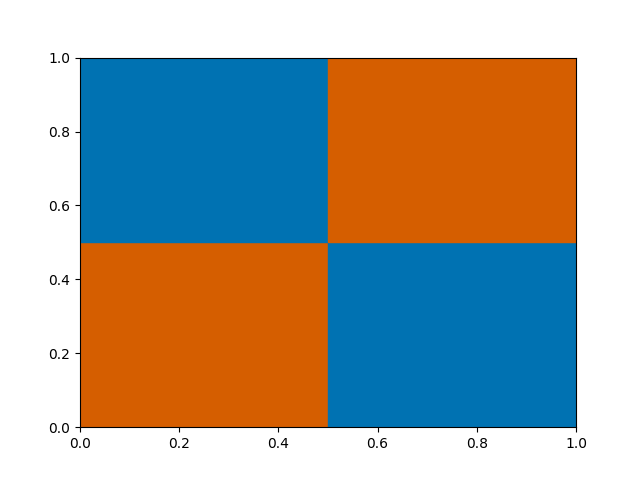

In [1]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

category_a_color = "#009E73" # (Green)
category_b_color = "#CC79A7" # (Magenta)

def reset_plot():
    plt.close()
    class_a_color = "#D55E00" # orange
    class_b_color = "#0072B2" # blue
    class_colors = iter([class_a_color, class_b_color, class_b_color, class_a_color])
    figure, axes = plt.subplots()
    
    #bottom left, top left, bottom right, top right
    origins = [(0,0), (0, 0.5), (0.5, 0), (0.5, 0.5)]
    for origin in origins:
        class_color = next(class_colors)
        rectangle = patches.Rectangle(origin, 0.5, 0.5, linewidth=1, edgecolor=class_color, facecolor=class_color)
        axes.add_patch(rectangle)


    input_area = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="g", facecolor='none')
    return axes, figure

reset_plot()
plt.show()

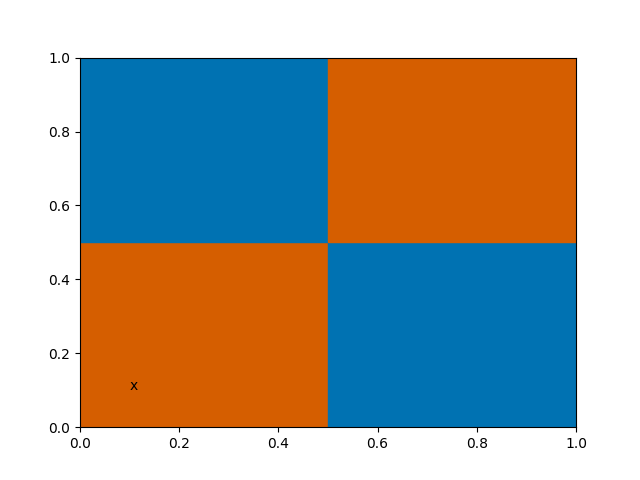

In [2]:
# first point - category A
axes, fig = reset_plot()
# This is `a` in Carpenter et al. 1992 - Fig. 1
first_point = np.array((0.1, 0.1))
axes.text(*first_point, "x")
plt.show()

In [3]:
# setup the initial parameters

# rho_a bar
baseline_vigilance = 0.9

# map field vigilance, rho_ab
map_field_vigilance = .95

# alpha
choice_parameter = 0.001

# beta
learning_rate = 1.0

commited_learning_rate = 0.75

#beta_ab
map_field_learning_rate = 1.0

In [4]:
# This is `A` (the result of F0) in Carpenter et al. 1992 - Fig. 1
# The value A is the concatenation of the first point (a) with its complement
complement_encoded_first_point = np.concatenate((first_point, 1-first_point))

In [5]:
number_of_complement_encoded_dimensions = complement_encoded_first_point.shape[0] # 4 dimensions
# the weight mapping between F1 and F2, the number of F2 nodes may grow, but the width (columns) is 
# limited to the complement encoded input size
weight_a = np.ones((1,number_of_complement_encoded_dimensions))

# the weight mapping between F2 and the map field F_ab - the width is limited to 
# the complement encoded size of the categories
# we only have 2 categories (A and B) that can be mapped to a one-dimensional vector 
# - (1) for category A, (0) for category B -
# with complement encoding, it is a two-dimensional vector
# category A - (1,0) - by C = (c, 1-c)
category_a_vector = np.array([[1,0]])

# category B - (0,1) - by C = (c, 1-c)
category_b_vector = np.array([[0,1]])

weight_ab = np.ones((1,2))

In [6]:
j = 0

# calculate category choice eq. 2
# Fuzzy AND is the point-wise minimum (Carpenter et al., 1992, Zadeh, 1965)
# |*| norm is the L-1 norm - vector sum (eq. 4)
category_choice_numerator = np.sum(np.minimum(complement_encoded_first_point, weight_a[j:]))
category_choice_denominator = choice_parameter + np.sum(weight_a[j:])
category_choice = category_choice_numerator / category_choice_denominator


In [7]:
# only one category currently, so Tj argmax = 0
# for the match function (see the text just above eq 7) the numerator is the same as the category choice, 
# and the denominator is |A|
match_function_denominator = np.sum(complement_encoded_first_point)
match_function = category_choice_numerator / match_function_denominator

# node 0 is uncommited so it triggers resonance
fuzzy_art_a_resonance = match_function >= baseline_vigilance

J = j

In [8]:
# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, 
# the category vector is used instead
x_ab = np.minimum(category_a_vector, weight_ab[J:])

In [9]:
# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, 
# is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance
map_field_resonance

True

In [10]:
# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_first_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))
display(weight_a[J, None])
display(weight_ab[J, None])

array([[0.1, 0.1, 0.9, 0.9]])

array([[1., 0.]])

In [11]:
def resonant_a_search(complement_encoded_point, vigilance, already_seen_nodes = None):
    global weight_a
    global weight_ab
    # first calculate all the category choice valules (see II.Category Choice in Carpenter et al. 1992)
    # create a T array to hold each of the T_j values, equal to the number of F2 nodes
    T = np.zeros((weight_a.shape[0]))
    for j in range(weight_a.shape[0]):
        category_choice_numerator = np.sum(np.minimum(complement_encoded_point, weight_a[j:]))
        category_choice_denominator = choice_parameter + np.sum(weight_a[j:])
        category_choice = category_choice_numerator / category_choice_denominator
        # this now fully reflects eq 2
        T[j] = category_choice

    fuzzy_art_a_resonance = False
    seen_nodes = []
    if already_seen_nodes:
        # keep track of nodes that have been disconfirmed
        # by the map field resonance/reset check
        seen_nodes.extend(already_seen_nodes)
        for node in already_seen_nodes:
            T[node] = 0
    
    while not fuzzy_art_a_resonance:
        # now to calculate J - eq 5
        J = np.argmax(T)

        # calculate the match function for the selected J (eq 7)
        match_function_numerator = np.sum(np.minimum(complement_encoded_point, weight_a[J:]))
        match_function_denominator = np.sum(weight_a[J:])
        match_function = match_function_numerator / match_function_denominator
        
        fuzzy_art_a_resonance = match_function >= vigilance
        if fuzzy_art_a_resonance:
            # return the winning category index
            return J
        
        # if not resonance, we reset, and per the text "Then the value of the choice function
        # T_J is set to 0 for the duration of the input presentation"
        T[J] = 0
        seen_nodes.append(J)
        
        if len(seen_nodes) >= len(T):
            # all existing category nodes have been checked, and none are
            # greater than the baseline vigilence, therefore add a new uncommited node
            weight_a = np.vstack((weight_a, np.ones((1,number_of_complement_encoded_dimensions))))
            weight_ab = np.vstack((weight_ab, np.ones((1,2))))
            # as we saw before, this new uncommited node, must be selected, so return the new index
            return len(T)


In [12]:
# now that we've seen two categories let's take a moment to refactor the category visualization
from matplotlib.axes import Axes
from matplotlib.figure import Figure

def visualize_category(category_index: int, 
                        category_color: str,
                        existing_axes: Axes = None,
                        existing_fig: Figure = None):
    """
    Visualize a category (category_index) from weight_a
    with the specified category_color
    If adding to an existing plot, pass in the existing_axes & existing_fig
    """    
    if existing_axes:
        axes = existing_axes
        fig = existing_fig
    else:
        axes, fig = reset_plot()
    

    # extract the first point from the first half (index 0 and 1) of the category weight 
    # called u_j in Fig 3
    bottom_left_point = (weight_a[category_index,0], weight_a[category_index,1])

    # extract the second point from the second half (index 2 and 3) of the category weight 
    # called v_j in Fig 3
    top_right_point = (weight_a[category_index,2], weight_a[category_index,3])

    # convert points to height and width for matplotlib, 
    # set a minimum 0.01x0.01 because the "rectangle" is a point initially
    height = max((1-top_right_point[1]) - bottom_left_point[1], 0.01)
    width = max((1-top_right_point[0]) - bottom_left_point[0], 0.01)

    category_rectangle = patches.Rectangle(bottom_left_point, width, height, linewidth=1, 
                                           edgecolor=category_color, facecolor=category_color)
    axes.add_patch(category_rectangle)

    return axes, fig

def visualize_categories():
    category_a = weight_ab[:, 0] > weight_ab[:, 1]
    a = None
    f = None
    for j in range(weight_a.shape[0]):
        is_category_a = category_a[j]
        color_to_use = category_b_color
        if is_category_a:
            color_to_use = category_a_color
        a, f = visualize_category(j, color_to_use, a, f)
    return a, f

Text(0.11, 0.1, 'x')

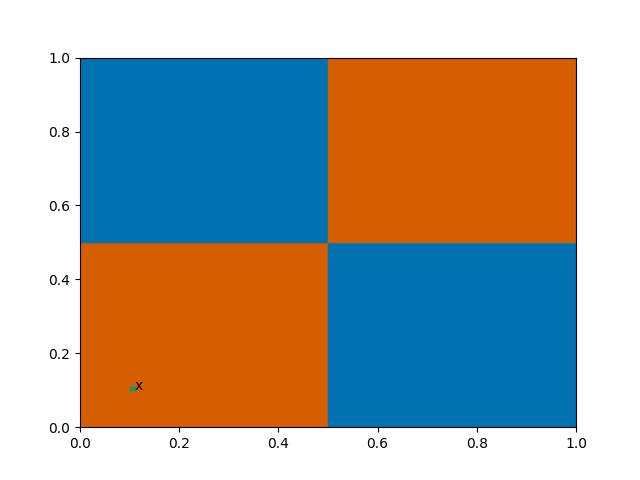

In [13]:
# fifth point - category A
fifth_point = np.array((0.11, 0.1))
a, f = visualize_categories()
a.text(*fifth_point, "x")

In [14]:
complement_encoded_fifth_point = np.concatenate((fifth_point, 1-fifth_point))

J = resonant_a_search(complement_encoded_fifth_point, baseline_vigilance)
display(J)

0

In [15]:
x_ab = np.minimum(category_a_vector, weight_ab[J:])

match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

In [16]:
weight_a[J, None] = (commited_learning_rate * np.minimum(complement_encoded_fifth_point, weight_a[J, None])) + ((1-commited_learning_rate) * weight_a[J, None])
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))
display(weight_a[J, None])
display(weight_ab[J, None])

array([[0.1   , 0.1   , 0.8925, 0.9   ]])

array([[1., 0.]])

Text(0.13, 0.1, 'x')

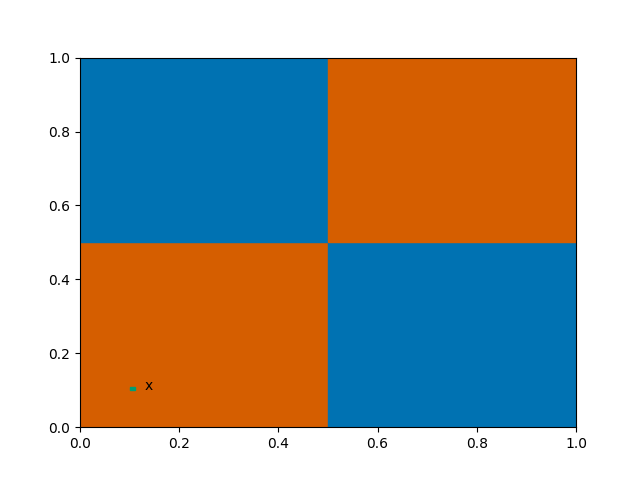

In [17]:
# sixth point - category A
sixth_point = np.array((0.13, 0.1))
a, f = visualize_categories()
a.text(*sixth_point, "x")

In [18]:
complement_encoded_sixth_point = np.concatenate((sixth_point, 1-sixth_point))

J = resonant_a_search(complement_encoded_sixth_point, baseline_vigilance)

display(J)

0

In [19]:
x_ab = np.minimum(category_a_vector, weight_ab[J:])

match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

weight_a[J, None] = (commited_learning_rate * np.minimum(complement_encoded_sixth_point, weight_a[J, None])) + ((1-commited_learning_rate) * weight_a[J, None])
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))

In [20]:
display(weight_a[J, None])
display(weight_ab[J, None])

array([[0.1     , 0.1     , 0.875625, 0.9     ]])

array([[1., 0.]])

Text(0.14, 0.1, 'x')

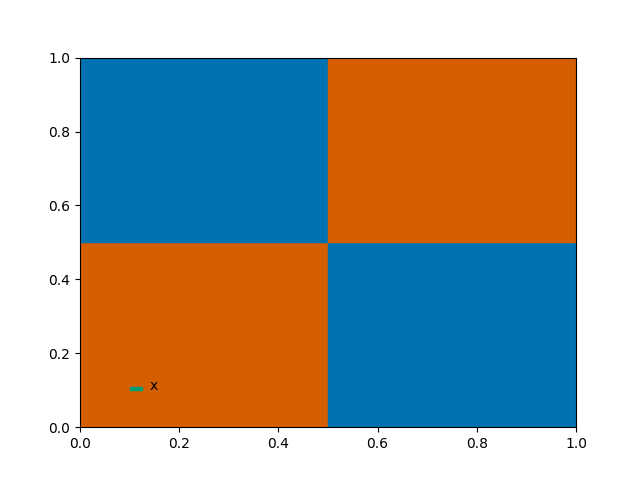

In [21]:
seventh_point = np.array((0.14, 0.1))
a, f = visualize_categories()
a.text(*seventh_point, "x")

In [22]:
complement_encoded_seventh_point = np.concatenate((seventh_point, 1-seventh_point))
# what happens if category b appears in an area where category_a is predicted?
# the match field resonance is False, leading to a map field reset
# this leads to an increase in vigilance (see around eq 35)
vigilance = baseline_vigilance
epsilon = 0.001
already_reset_nodes = []
map_field_resonance = False
while not map_field_resonance:
    J = resonant_a_search(complement_encoded_seventh_point, vigilance, already_reset_nodes)
    x_ab = np.minimum(category_b_vector, weight_ab[J:])

    match_tracking = np.sum(x_ab)/np.sum(category_b_vector)
    map_field_resonance = match_tracking >= map_field_vigilance
    if map_field_resonance:
            break
    already_reset_nodes.append(J)

    vigilance += epsilon

display(J)

1

In [23]:
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_seventh_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_b_vector, weight_ab[J:]))

In [24]:
display(weight_a.shape)
display(weight_a[J, None])
display(weight_ab[J, None])

(2, 4)

array([[0.14, 0.1 , 0.86, 0.9 ]])

array([[0., 1.]])